In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt

In [3]:
from sklearn import model_selection
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import neighbors
from sklearn import svm
from sklearn import metrics

In [4]:
from sklearn import feature_extraction

In [7]:
data = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None, names=['Sentiment', 'Tweet ID', 'Date', 'Query', 'Username', 'Tweet'])

In [8]:
data.head(2)

,Sentiment,Tweet ID,Date,Query,Username,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


Sentiment atribut oznacava da li je tvit pozitivan ili negativan. Vrednosti oznacene sa 0 odgovaraju negativnom sentimentu, 2 odgovara neutralnom sentimentu, dok 4 odgovara pozitivnom sentimentu

In [9]:
sentiments = data['Sentiment'].value_counts().keys()
sentiments

Int64Index([0, 4], dtype='int64')

In [10]:
np.unique(sentiments)

array([0, 4])

Kao sto mozemo da primetimo, uklonjeni su svi neutralni sentimenti, sa tim na umu su remapirane ciljne vrednosti u 0 (negativan) i 1 (pozitivan)

In [11]:
def username_removal(string):

    for i in range(string.count('@')):
        username_begin_index = string.find('@')
        username_end_index = string[username_begin_index::].find(' ') + username_begin_index

        string = string.replace(string[username_begin_index:username_end_index+1],' ')

    return string

In [12]:
data['Tweet'] = data['Tweet'].apply(username_removal)

In [13]:
def Sentiment_remap(x):
    if x == 0:
        return 0
    else:
        return 1

In [14]:
data['Sentiment'] = data['Sentiment'].apply(Sentiment_remap)

In [15]:
x = data['Tweet']
y = data['Sentiment']

In [16]:
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (1600000,)
y shape:  (1600000,)


## Potrebno je napraviti vokabular

In [17]:
import string
import nltk
from nltk import tokenize
from nltk.corpus import stopwords

In [18]:
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

koristimo 15% podataka zbog vremenske zahtevnosti treniranja mreza

In [19]:
x_train_validation, x_test, y_train_validation, y_test = model_selection.train_test_split(x,y,train_size=0.1,test_size=0.05, stratify=y, random_state=7)

In [20]:
x_train, x_validation, y_train, y_validation = model_selection.train_test_split(x_train_validation, y_train_validation, train_size=0.8, stratify=y_train_validation, random_state=7)

# Stemovanje

Napravljena je funkcija preko koje se tweetovima dodaju vestacki koreni, ukoliko postoje interpunkcijski znakovi, stop reci, ili cifre, oni se preskacu.

In [21]:
def tweet_tokenizer(tweet):
    tweet_tokens = nltk.tokenize.word_tokenize(tweet)

    tweet_stems = []
    stemmer = nltk.stem.LancasterStemmer()

    for token in tweet_tokens:
        if token in string.punctuation:
            continue
        if token in stopwords_list:
            continue
        if token.isdigit():
            continue

        stem = stemmer.stem(token)
        tweet_stems.append(stem)

    return tweet_stems

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
stopwords_list = stopwords.words('english')

In [27]:
min_freq = [32,33,34,35,36]
max_freq = [7000,7500,8000,8500,9000]

In [28]:
best_min_freq = None
best_max_freq = None
best_score = float('-inf')

for minfreq in min_freq:
    for maxfreq in max_freq:
        model = linear_model.LinearRegression()

        tweet_count_vectorizer = feature_extraction.text.CountVectorizer(min_df = minfreq, max_df = maxfreq, stop_words=stopwords.words('english'))
        tweet_count_vectorizer.fit(x_train)

        x_train_vectorized = tweet_count_vectorizer.transform(x_train)
        x_test_vectorized = tweet_count_vectorizer.transform(x_validation)

        model.fit(x_train_vectorized,y_train)
        score = model.score(x_test_vectorized, y_validation)

        if score > best_score:
            best_score = score
            best_min_freq = minfreq
            best_max_freq = maxfreq

print('best_score = {}, best_min_freq = {}, best_max_freq = {}'.format(best_score, best_min_freq, best_max_freq))



best_score = 0.28694873362320916, best_min_freq = 32, best_max_freq = 7500


In [29]:
count_vectorizer_stem = feature_extraction.text.CountVectorizer(min_df=best_min_freq, max_df=best_max_freq, tokenizer=tweet_tokenizer, stop_words=stopwords.words('english'))

In [30]:
count_vectorizer_stem.fit(x_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'nee', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


CountVectorizer(max_df=7500, min_df=32,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tweet_tokenizer at 0x78324a2439a0>)

In [31]:
feature_names = count_vectorizer_stem.get_feature_names_out()
vocab_size = len(feature_names)
vocab_size

2633

In [32]:
x_train_vectorized = count_vectorizer_stem.transform(x_train)
x_test_vectorized = count_vectorizer_stem.transform(x_test)

# Model 1 - logisticka regresija

In [33]:
model1 = linear_model.LogisticRegression()

In [34]:
model1.fit(x_train_vectorized,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Tacnost modela na trening i test skupu

In [35]:
model1_skor_train = model1.score(x_train_vectorized, y_train)
model1_skor_test = model1.score(x_test_vectorized, y_test)

In [36]:
print("skor na podacima za treniranje: ", model1_skor_train)
print('skor na podacima za testiranje: ', model1_skor_test)

skor na podacima za treniranje:  0.76915625
skor na podacima za testiranje:  0.7569375


### Matrica konfuzije - logisticka regresija

In [37]:
y_predicted_lr = model1.predict(x_test_vectorized)

In [38]:
matrica_konfuzije_lr = metrics.confusion_matrix(y_test, y_predicted_lr)
matrica_konfuzije_lr

array([[28842, 11158],
       [ 8287, 31713]])

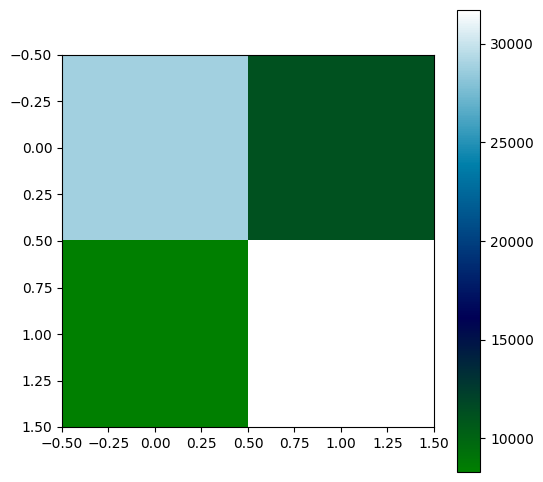

In [39]:
plt.figure(figsize=(6, 6))
plt.imshow(matrica_konfuzije_lr, cmap='ocean')
plt.colorbar()
plt.show()

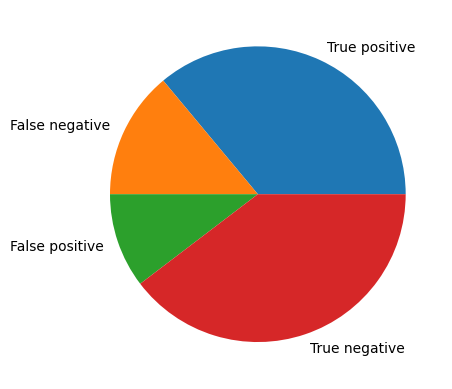

In [40]:
plt.pie(matrica_konfuzije_lr.ravel(), labels=['True positive', 'False negative','False positive', 'True negative'])
plt.show()

# MODEL 2 - linearni SVM

In [41]:
model2 = svm.LinearSVC()

In [42]:
model2.fit(x_train_vectorized, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [43]:
model2_skor_train = model2.score(x_train_vectorized, y_train)
model2_skor_test = model2.score(x_test_vectorized, y_test)

In [44]:
print("skor na podacima za treniranje: ", model2_skor_train)
print('skor na podacima za testiranje: ', model2_skor_test)

skor na podacima za treniranje:  0.7682578125
skor na podacima za testiranje:  0.7566625


In [45]:
y_pred_svm = model2.predict(x_test_vectorized)
matrica_konfuzije_svm = metrics.confusion_matrix(y_test, y_pred_svm)
matrica_konfuzije_svm

array([[28572, 11428],
       [ 8039, 31961]])

### Matrica konfuzije - linearni SVM

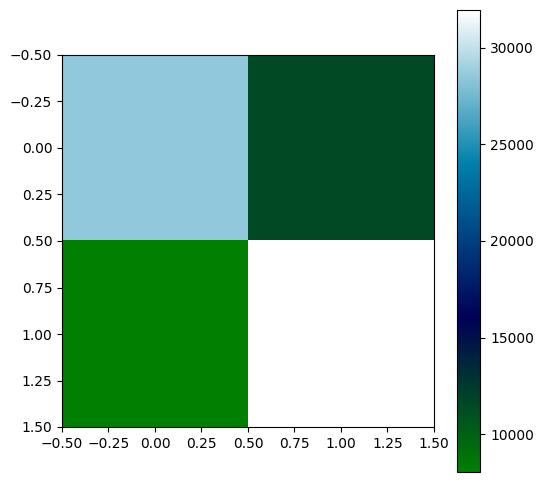

In [46]:
plt.figure(figsize=(6, 6))
plt.imshow(matrica_konfuzije_svm, cmap='ocean')
plt.colorbar()
plt.show()

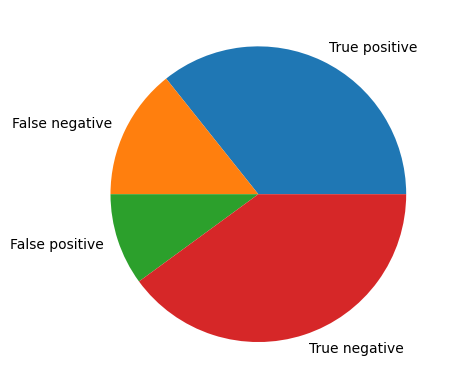

In [47]:
plt.pie(matrica_konfuzije_svm.ravel(), labels=['True positive', 'False negative','False positive', 'True negative'])
plt.show()

# MODEL 3 - k najblizih suseda

In [48]:
num_neighbors = [6,8,10,12,15]

In [49]:
x_train_vectorized = count_vectorizer_stem.transform(x_train)
x_validation_vectorized = count_vectorizer_stem.transform(x_validation)

In [50]:
best_score = float('-inf')
best_neigh = None

for neigh in num_neighbors:
    model = neighbors.KNeighborsClassifier(n_neighbors=neigh)
    model.fit(x_train_vectorized, y_train)
    score = model.score(x_validation_vectorized, y_validation)

    if score > best_score:
        best_score = score
        best_neigh = neigh
print('best score = {}, best neighbor num = {}'.format(best_score, best_neigh))

best score = 0.6884375, best neighbor num = 12


Napravljen je model sa najboljim hiperparametrima

In [51]:
model3 = neighbors.KNeighborsClassifier(n_neighbors=best_neigh)

In [52]:
model3.fit(x_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=12)

In [53]:
model3_skor_train = model3.score(x_train_vectorized, y_train)
model3_skor_test = model3.score(x_test_vectorized, y_test)

In [54]:
print("skor na podacima za treniranje: ", model3_skor_train)
print('skor na podacima za testiranje: ', model3_skor_test)

skor na podacima za treniranje:  0.736984375
skor na podacima za testiranje:  0.6838625


In [55]:
y_pred_kneigh = model3.predict(x_test_vectorized)
matrica_konfuzije_kneigh = metrics.confusion_matrix(y_test, y_pred_kneigh)
matrica_konfuzije_kneigh

array([[25410, 14590],
       [10701, 29299]])

### Matrica konfuzije - k najblizih suseda

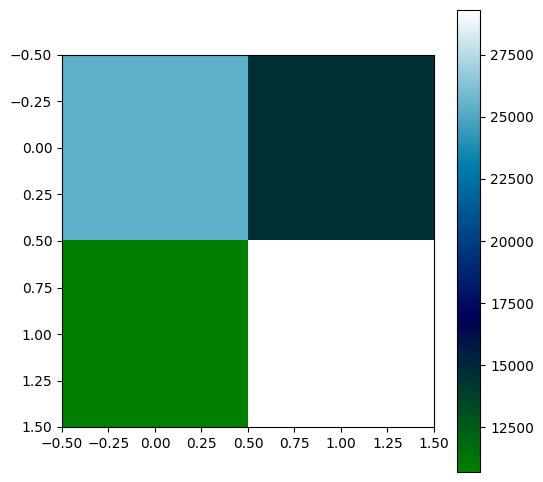

In [56]:
plt.figure(figsize=(6, 6))
plt.imshow(matrica_konfuzije_kneigh, cmap='ocean')
plt.colorbar()
plt.show()

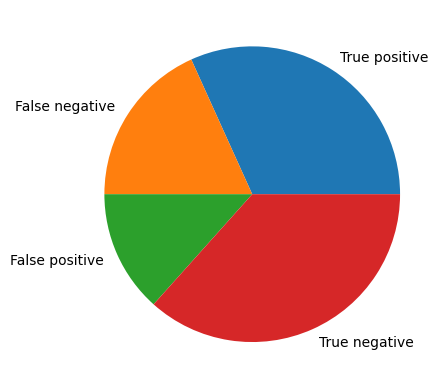

In [57]:
plt.pie(matrica_konfuzije_kneigh.ravel(), labels=['True positive', 'False negative','False positive', 'True negative'])
plt.show()

## LEMATIZACIJA

Uradjena je lematizacija tokena, tj. pridruzivanje korena svakom tokenu

In [58]:
def get_wordnet_pos_tag(token):
    #uparujemo prvi karakter PennTreebank POS obelezja sa odgovarajucim WordNet POS obelezjem
    pos_tag_dict = {
        'N' : 'n',
        'V' : 'v',
        'J' : 'a',
        'R' : 'r'
    }

    penn_pos_tag = nltk.pos_tag([token])[0][1][0]

    #mapiramo ga u odgovarajuce WordNet POS obelezje ili postavljamo podrazumevano na POS obelezje imenice
    if penn_pos_tag in pos_tag_dict:
        return pos_tag_dict[penn_pos_tag]
    else:
        return 'n'

In [59]:
def tweet_lemma_tokenizer(tweet):
    tweet_tokens = nltk.tokenize.word_tokenize(tweet)

    tweet_lemmas = []

    lemmatizer = nltk.stem.WordNetLemmatizer()

    for token in tweet_tokens:
        if token in string.punctuation:
            continue
        if token in stopwords_list:
            continue
        if token.isdigit():
            continue

        pos_tag = get_wordnet_pos_tag(token)
        lemma = lemmatizer.lemmatize(token, pos_tag)
        tweet_lemmas.append(lemma)

    return tweet_lemmas

In [60]:
count_vectorizer_lemm = feature_extraction.text.CountVectorizer(min_df=best_min_freq, max_df=best_max_freq, tokenizer=tweet_lemma_tokenizer,stop_words=stopwords.words('english'))

In [65]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [66]:
count_vectorizer_lemm.fit(x_train)

CountVectorizer(max_df=7500, min_df=32,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tweet_lemma_tokenizer at 0x7832447e1c60>)

In [67]:
x_train_vectorized_lemm = count_vectorizer_lemm.transform(x_train)
x_test_vectorized_lemm = count_vectorizer_lemm.transform(x_test)

In [68]:
feature_names = count_vectorizer_lemm.get_feature_names_out()
vocab_size = len(feature_names)
vocab_size

2745

# Model 1 - logisticka regresija

In [69]:
model4 = linear_model.LogisticRegression()

In [70]:
model4.fit(x_train_vectorized_lemm,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Tacnost modela na trening i test skupu

In [71]:
model4_skor_train = model4.score(x_train_vectorized_lemm, y_train)
model4_skor_test = model4.score(x_test_vectorized_lemm, y_test)

In [72]:
print("skor na podacima za treniranje: ", model4_skor_train)
print('skor na podacima za testiranje: ', model4_skor_test)

skor na podacima za treniranje:  0.77015625
skor na podacima za testiranje:  0.7571375


### Matrica konfuzije - logisticka regresija

In [73]:
y_predicted_lr = model4.predict(x_test_vectorized_lemm)

In [74]:
matrica_konfuzije_lr = metrics.confusion_matrix(y_test, y_predicted_lr)
matrica_konfuzije_lr

array([[28905, 11095],
       [ 8334, 31666]])

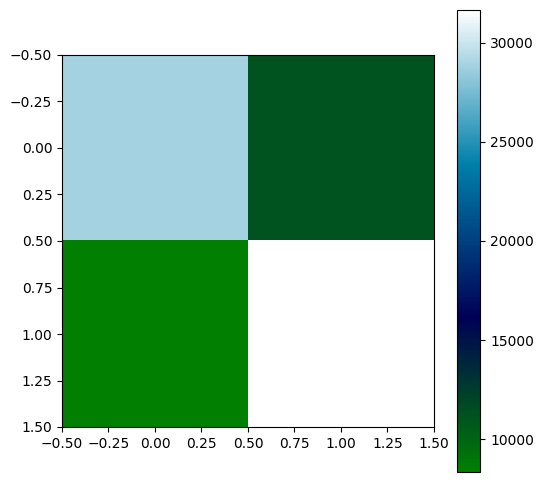

In [75]:
plt.figure(figsize=(6, 6))
plt.imshow(matrica_konfuzije_lr, cmap='ocean')
plt.colorbar()
plt.show()

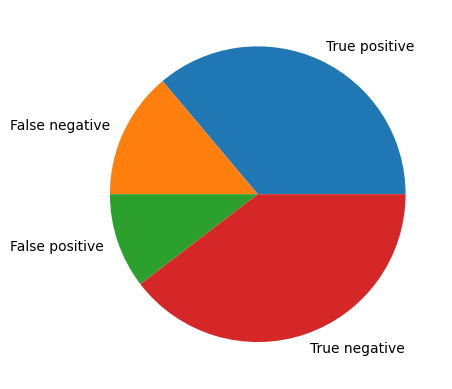

In [76]:
plt.pie(matrica_konfuzije_lr.ravel(), labels=['True positive', 'False negative','False positive', 'True negative'])
plt.show()

# MODEL 2 - linearni SVM

In [77]:
model5 = svm.LinearSVC()

In [78]:
model5.fit(x_train_vectorized_lemm, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [79]:
model5_skor_train = model5.score(x_train_vectorized_lemm, y_train)
model5_skor_test = model5.score(x_test_vectorized_lemm, y_test)

In [80]:
print("skor na podacima za treniranje: ", model5_skor_train)
print('skor na podacima za testiranje: ', model5_skor_test)

skor na podacima za treniranje:  0.769265625
skor na podacima za testiranje:  0.7565375


In [81]:
y_pred_svm = model5.predict(x_test_vectorized_lemm)
matrica_konfuzije_svm = metrics.confusion_matrix(y_test, y_pred_svm)
matrica_konfuzije_svm

array([[28594, 11406],
       [ 8071, 31929]])

### Matrica konfuzije - linearni SVM

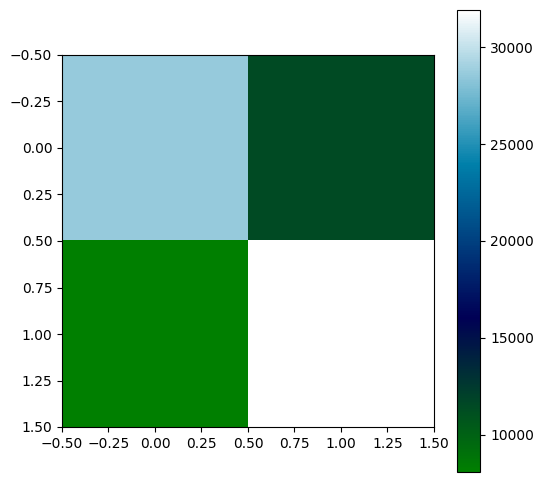

In [82]:
plt.figure(figsize=(6, 6))
plt.imshow(matrica_konfuzije_svm, cmap='ocean')
plt.colorbar()
plt.show()

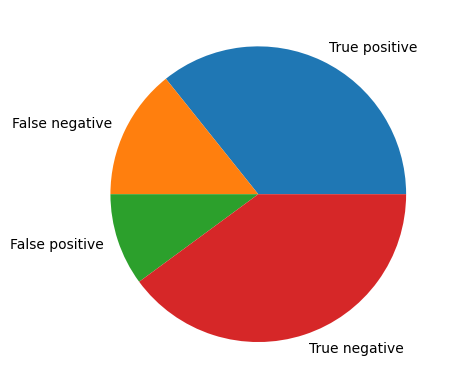

In [83]:
plt.pie(matrica_konfuzije_svm.ravel(), labels=['True positive', 'False negative','False positive', 'True negative'])
plt.show()

# MODEL 3 - k najblizih suseda

In [84]:
model6 = neighbors.KNeighborsClassifier(n_neighbors=best_neigh)

In [85]:
model6.fit(x_train_vectorized_lemm, y_train)

KNeighborsClassifier(n_neighbors=12)

In [86]:
model6_skor_train = model6.score(x_train_vectorized_lemm, y_train)
model6_skor_test = model6.score(x_test_vectorized_lemm, y_test)

In [87]:
print("skor na podacima za treniranje: ", model6_skor_train)
print('skor na podacima za testiranje: ', model6_skor_test)

skor na podacima za treniranje:  0.73496875
skor na podacima za testiranje:  0.6819125


In [88]:
y_pred_kneigh = model6.predict(x_test_vectorized_lemm)
matrica_konfuzije_kneigh = metrics.confusion_matrix(y_test, y_pred_kneigh)
matrica_konfuzije_kneigh

array([[26269, 13731],
       [11716, 28284]])

### Matrica konfuzije - k najblizih suseda

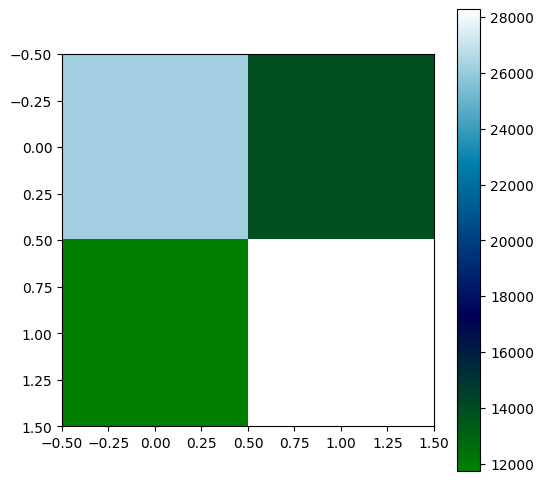

In [89]:
plt.figure(figsize=(6, 6))
plt.imshow(matrica_konfuzije_kneigh, cmap='ocean')
plt.colorbar()
plt.show()

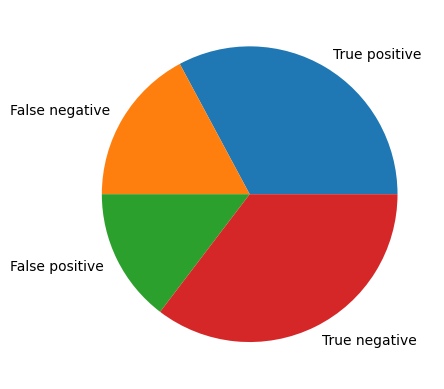

In [90]:
plt.pie(matrica_konfuzije_kneigh.ravel(), labels=['True positive', 'False negative','False positive', 'True negative'])
plt.show()

# Stemovanje

In [91]:
rezultati = [[model1_skor_train, model1_skor_test],[model2_skor_train,model2_skor_test],[model3_skor_train,model3_skor_test]]
pd.DataFrame(rezultati, columns=["score na treniranju", "score na testu"], index = ['Log Reg','SVM','K-neigh'])

,score na treniranju,score na testu
Log Reg,0.769156,0.756938
SVM,0.768258,0.756663
K-neigh,0.736984,0.683863


# Lematizacija

In [92]:
rezultati = [[model4_skor_train, model4_skor_test],[model5_skor_train,model5_skor_test],[model6_skor_train,model6_skor_test]]
pd.DataFrame(rezultati, columns=["score na treniranju", "score na testu"], index = ['Log Reg','SVM','K-neigh'])

,score na treniranju,score na testu
Log Reg,0.770156,0.757138
SVM,0.769266,0.756537
K-neigh,0.734969,0.681913


In [93]:
from joblib import dump, load

In [96]:
dump(count_vectorizer_stem, 'vectorizers_stem')

['vectorizers_stem']

In [97]:
dump(count_vectorizer_lemm, 'vectorizers_lemm')

['vectorizers_lemm']

In [98]:
dump(model1, 'LR_stem.joblib')

['LR_stem.joblib']

In [99]:
dump(model2, 'SVM_stem.joblib')

['SVM_stem.joblib']

In [100]:
dump(model3, 'Kneigh_stem.joblib')

['Kneigh_stem.joblib']

In [101]:
dump(model4, 'LR_lemm.joblib')

['LR_lemm.joblib']

In [102]:
dump(model5, 'SVM_lemm.joblib')

['SVM_lemm.joblib']

In [103]:
dump(model6, 'Kneigh_lemm.joblib')

['Kneigh_lemm.joblib']